# Kapetyn Murnane Labs Ptychography Simulation Workflow

This notebook should be a one-stop shop for simulating Ptychograph data from an image (todo: or set of images.)

Figures are used as diagnostic and not stored. 


In [1]:
from ptypy import utils as u
from ptypy.core import Ptycho, geometry, xy, View, POD

import datetime
import sys,os

sys.path.insert(1, 'C:\Users\jspott\PycharmProjects\kmlabs.cdi.processing\Scripts')
import KMutils

import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook


Some notes here on settings:

- Two out of three for 'scanPoints', 'extent', and 'probeSpacing' must be selected. The third will be back calculated. So, if I specify a spiral with 10 rings/layers ('scanPoints') that covers a 1 mm 'extent', my probe spacing will be calculated to be 0.1 mm.
- Below please set the parameters. Simulation settings left as None will use the default setting!


In [2]:
simulationImage = None 
#NOT YET IMPLEMENTED. This should be a directory where an image lives; how can I upload an image remotely? Defaults to flower pattern

simulationSettings = {
    'title' : 'basic_simulation_moon_probe'
}

useDefaults = False
defaultSettings = {
    'title' : eval('datetime.datetime.now().strftime(\'%Y-%m-%d--%H-%M-%S\')'),
    'rootDir' : 'C:\Users\Public\Documents\Ptychography\Simulations\\',
    'energy' : None,
    'propagation' : 'farfield',
    'wavelength' : 532e-9,
    'detectorDistance' : 150e-3,
    'detectorPixelSize' : 24e-6,
    'detectorSize' : 256,
    'scanModel' : 'round', #Options are...
    'probeWidth' : None, #defaults to 1/5 of frame size
    'probeHeight' : None, #defaults to 1/5 of frame size
    'photons' : 1e9,
    'probeSpacing' : None, #defaults to 1/8 of frame size
    'scanPoints' : None,
    'extent' : None #defaults to 1.5* frame size
}

shoeboxSettings = {
    'energy' : None, #needs to be explicitly declared b/c of default value (energy takes prescidence over wavelength)
    'propagation' : 'farfield',
    'wavelength' : 3e-8,
    'detectorDistance' : 50e-3,
    'detectorPixelSize' : 13.5e-6,
    'detectorSize' : 2048, #detector width/height in pixels
    'probeWidth' : 5e-6,
    'probeHeight' : 10e-6, #if different from width, probe calculated as ellipse
    'probeOverlap' : 0.8, #overlap between probe spots.
    'photons' : 1e9, #number of photons @ sample (check this!)
    'probeSpacing' : 'from_overlap',
    'scanPoints' : 10, #this is the number of steps the ring takes outwards, counted from left to right. Confusing, right?
    'extent' : None
}

#simulationSettings = dict(simulationSettings, **shoeboxSettings)

for setting in defaultSettings:
    if simulationSettings.get(setting) is None:
        simulationSettings[setting] = defaultSettings[setting]
    

In [3]:
save_path = os.path.join(simulationSettings['rootDir'], simulationSettings['title'])
i = 0
while os.path.exists(save_path):
    i+=1
    if i > 1:
        digits = int(np.log10(i)) + 1
        save_path = save_path[:-digits]
    save_path = save_path + str(i)

os.mkdir(save_path)

image_path = os.path.join(save_path, 'images')
os.mkdir(image_path)

#### Initiating the Ptycho manager 
Changing the verbose level helps with diagnostics (5 is max, 1 is min)

In [4]:
ptychoParams = u.Param(verbose_level = 1,
                       data_type = 'single')

P = Ptycho(ptychoParams)

WARNING root - Failed registering instance of <class 'ptypy.core.ptycho.Ptycho'> with ID Ptycho to object None


#### Creating the probe

Pulls select settings (wavelength, distance, pixel size) to create the probe.

Working with a 3.325 x 3.325mm frame at sample, with 12988.28nm resolution.
This is the simulated probe.


<IPython.core.display.Javascript object>

This is the simulated forward propogation of the probe.


<IPython.core.display.Javascript object>


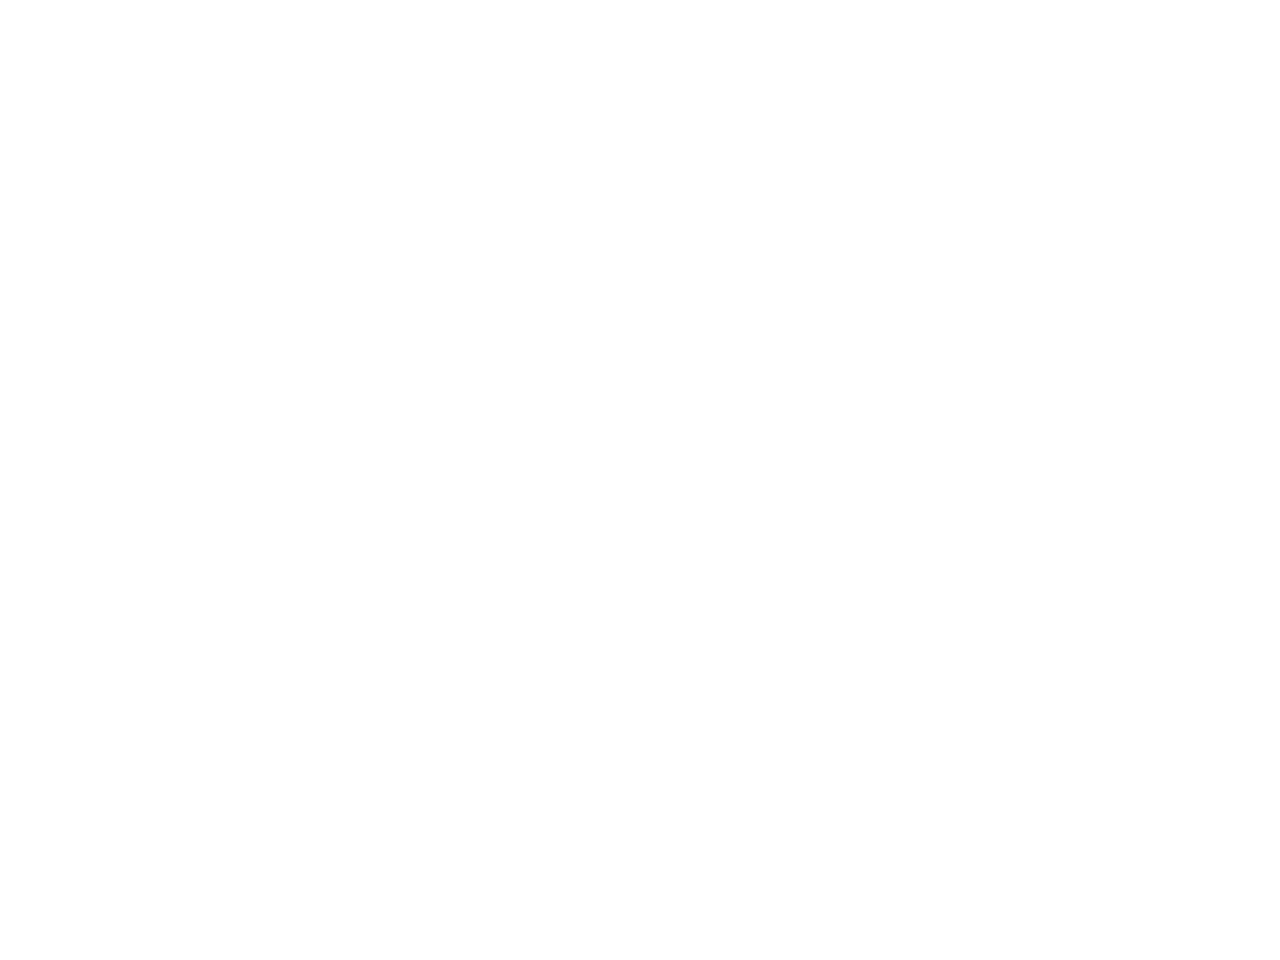

In [5]:
gKeys ={'wavelength': 'lam', 'detectorDistance': 'distance', 'detectorPixelSize': 'psize', 'detectorSize': 'shape', 'energy' : 'energy', 'propagation': 'propagation'}
gSettings = {}
for key, value in gKeys.items():
    gSettings[value] = simulationSettings.get(key)
geoParams = u.Param(gSettings)
G = geometry.Geo(owner = P, pars = geoParams)

frameSize = G.shape*G.resolution
print("Working with a {0:.3f} x {0:.3f}mm frame at sample, with {1:.2f}nm resolution.".format(tuple(frameSize*1e3)[0], G.resolution[0]*1e9))

#make the storage for the probe
pr_shape = (1,) + tuple(G.shape)
pr = P.probe.new_storage(shape=pr_shape, psize=G.resolution)

#make the grid coords for the probe
y, x = G.propagator.grids_sam

probeWidth, probeHeight = simulationSettings['probeWidth'], simulationSettings['probeHeight']
if probeWidth == None or probeHeight == None:
    probeWidth, probeHeight = frameSize/5

apert_circle = u.smooth_step(frameSize[0]/5-np.sqrt(x**2+y**2), 1e-6)
apert_oval = u.smooth_step(1 - np.sqrt(((x**2) / ((probeWidth / 2) ** 2)) + ((y ** 2) / ((probeHeight / 2) ** 2))), 1e-6)

from ptypy.resources import moon_pr
apert = -moon_pr(G.shape)

pr.fill(apert)
pr.data *= np.sqrt(simulationSettings['photons']/np.sum(pr.data*pr.data.conj()))

print('This is the simulated probe.')
fig = u.plot_storage(pr,1,channel='c')
fig.savefig(image_path+'/simulated_probe.png', dpi=300)

ill = pr.data[0]
propagated_ill = G.propagator.fw(ill)
print('This is the simulated forward propogation of the probe.')
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(np.log10(np.abs(propagated_ill)+1))
plt.colorbar(im)
#fig.savefig('propogated_ill.png', dpi=300)


#### Calculating the grid positions

Scan grid generated with 116 positions.


<IPython.core.display.Javascript object>


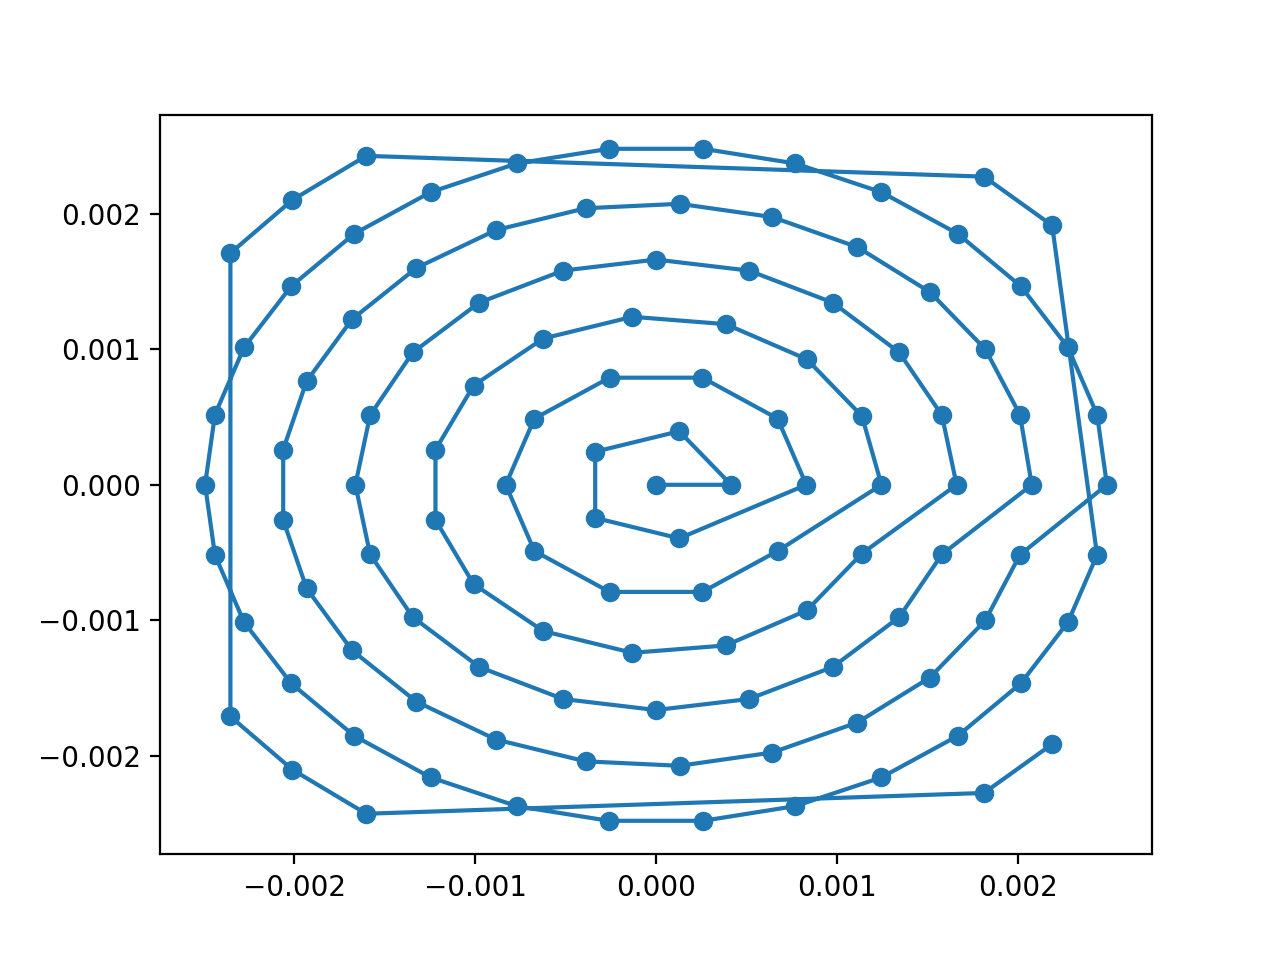

In [7]:
if simulationSettings['probeSpacing'] is 'from_overlap':
    simulationSettings['probeSpacing'] = KMutils.calcStepSize(min(simulationSettings['probeHeight'],simulationSettings['probeWidth'])/2,simulationSettings['probeOverlap'])

ss = simulationSettings

#giving minimum params for scangrid
if [ss['probeSpacing'], ss['scanPoints'], ss['extent']].count(None) > 1:
    ss['extent'] = frameSize[0]*1.5
    ss['probeSpacing'] = frameSize[0]/8
    
posKeys = {'scanModel': 'model', 'probeSpacing': 'spacing', 'scanPoints': 'steps', 'extent':'extent'}
posSettings = {}
for key, value in posKeys.items():
    posSettings[value] = simulationSettings[key]
posParams = u.Param(posSettings)

positions = xy.from_pars(posParams)

print('Scan grid generated with {} positions.'.format(len(positions)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(positions[:,1], positions[:, 0], 'o-')
fig.savefig(image_path+'/scanpattern-{}.png'.format(G.shape), dpi=300)


#### Creating buffers for the object

In [8]:
oar = View.DEFAULT_ACCESSRULE.copy()
oar.storageID = 'S00'
oar.psize = G.resolution
oar.layer = 0
oar.shape = G.shape
oar.active = True

for pos in positions:
    r = oar.copy()
    r.coord = pos
    V = View(P.obj, None, r)

P.obj.reformat()

#### Importing the image into the object

<IPython.core.display.Javascript object>


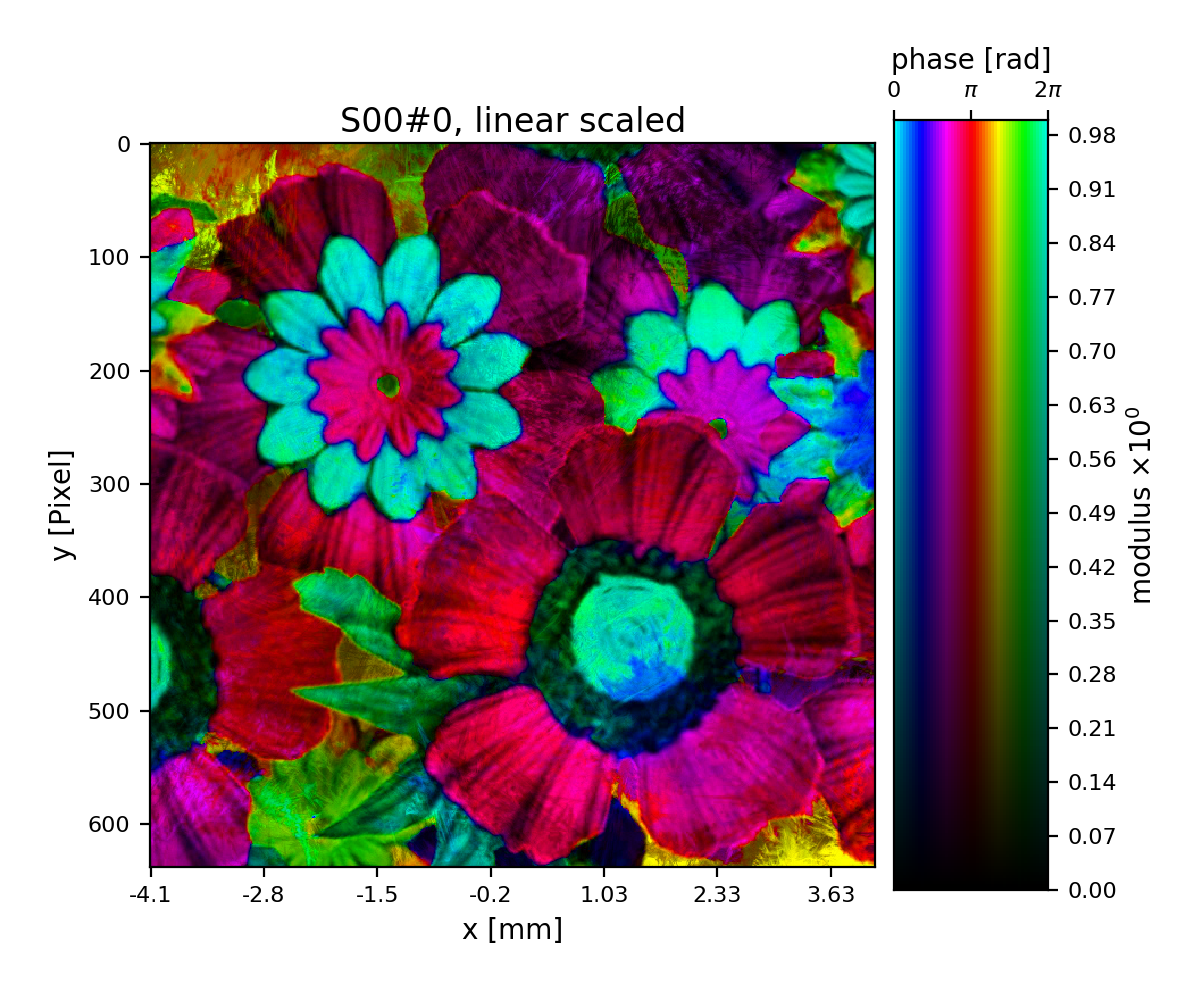

In [10]:
from ptypy.resources import flower_obj
storage = P.obj.storages['S00']
if simulationImage is None:
    storage.fill(flower_obj(storage.shape[-2:]))
else:
    pass
    # 1) grab image from wherever; 2) convert to np array; 3)resize image? maybe have a scaling factor? 
    # rem, the image will fill storage, be truncated if too small, and then numpy.resize will start repeating the image in a grid.
    #storage.fill('cameraman.png') # 'a float is required...

fig = u.plot_storage(storage, 5)
fig.savefig(image_path+'/object-{}.png'.format(G.shape) , dpi=300)



#todo - I'd love to subclass get_view_coverage for probes - this will show how much of the object is covered by the scan. 
#Test_C = Container(data_type='int')
#View_Coverage = Test_C.new_storage(shape=storage.shape)
#View_Coverage.data[:] = storage.get_view_coverage()
#fig = u.plot_storage(View_Coverage,1000)
#fig.savefig('images/coverage.png', dpi=300)

In [11]:
image_array = storage.data
plt.close('all')
plt.hist(image_array.flatten(),256,[0,50])
plt.savefig(image_path + '/histogram', dpi=300)
    

<IPython.core.display.Javascript object>

C:\Users\jspott\AppData\Local\Continuum\anaconda3\envs\py2\lib\site-packages\numpy\lib\function_base.py:589: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp_a_data = tmp_a.astype(float)


In [12]:
#creating views for exit wave, diff pattern; etc

objviews = P.obj.views.values()

probe_ar = View.DEFAULT_ACCESSRULE.copy()
probe_ar.psize = G.resolution
probe_ar.shape = G.shape
probe_ar.active = True
probe_ar.storageID = pr.ID
prview = View(P.probe, None, probe_ar)

exit_ar = probe_ar.copy()
exit_ar.layer = -1

diff_ar = probe_ar.copy()
diff_ar.layer = -1
diff_ar.psize = G.psize
mask_ar = diff_ar.copy()

pods = []


for obview in objviews:
    #prview = View(P.probe, None, probe_ar) #duplicate line?
    exit_ar.layer += 1
    diff_ar.layer += 1
    exview = View(P.exit, None, exit_ar)
    maview = View(P.mask, None, mask_ar)
    diview = View(P.diff, None, diff_ar)
    views = {'probe': prview,
             'obj': obview,
             'exit': exview,
             'diff': diview,
             'mask': maview}
    pod = POD(P, model=None, ID=None, views=views, geometry=G)
    pods.append(pod)

#this step is the most memory intensive - anything with more than 16 GB RAM should be able to handle it. renable the formatted reports to get an idea if stuck.
for C in [P.mask, P.exit, P.diff, P.probe]:
    #print(C.formatted_report())
    C.reformat()
    #print(C.formatted_report())

In [13]:
#now we're making the actual diffraction patterns. These 4 lines are more computationally expensive than the rest of the workflow! 
for pod in pods:
    pod.exit = pod.probe * pod.object
    pod.diff = np.random.poisson(np.abs(pod.fw(pod.exit))**2)
    pod.mask = np.ones_like(pod.diff)

This is the first and second exit wave in the series and their corresponding diffraction patterns.


<IPython.core.display.Javascript object>


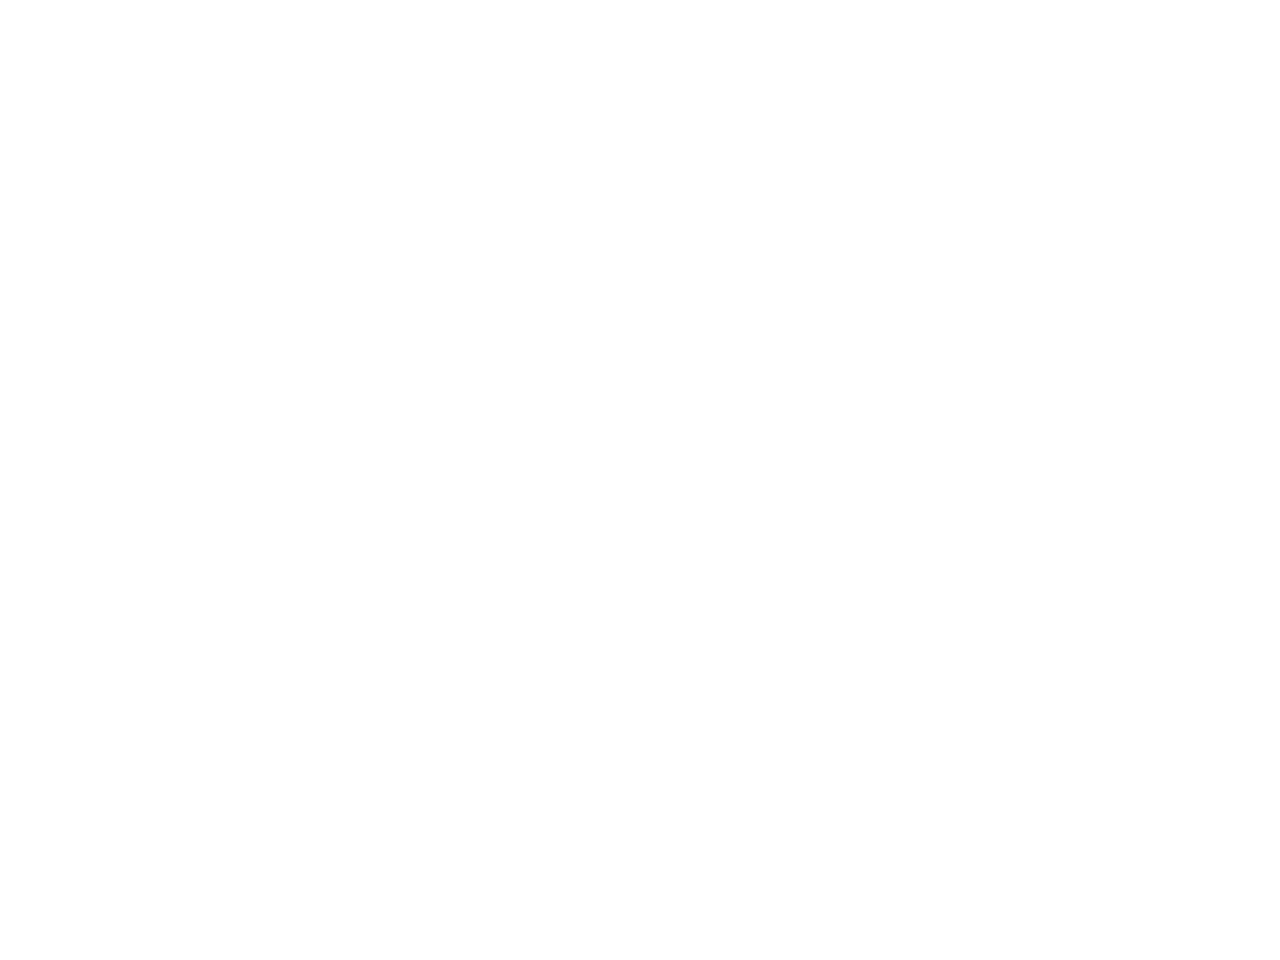

<IPython.core.display.Javascript object>


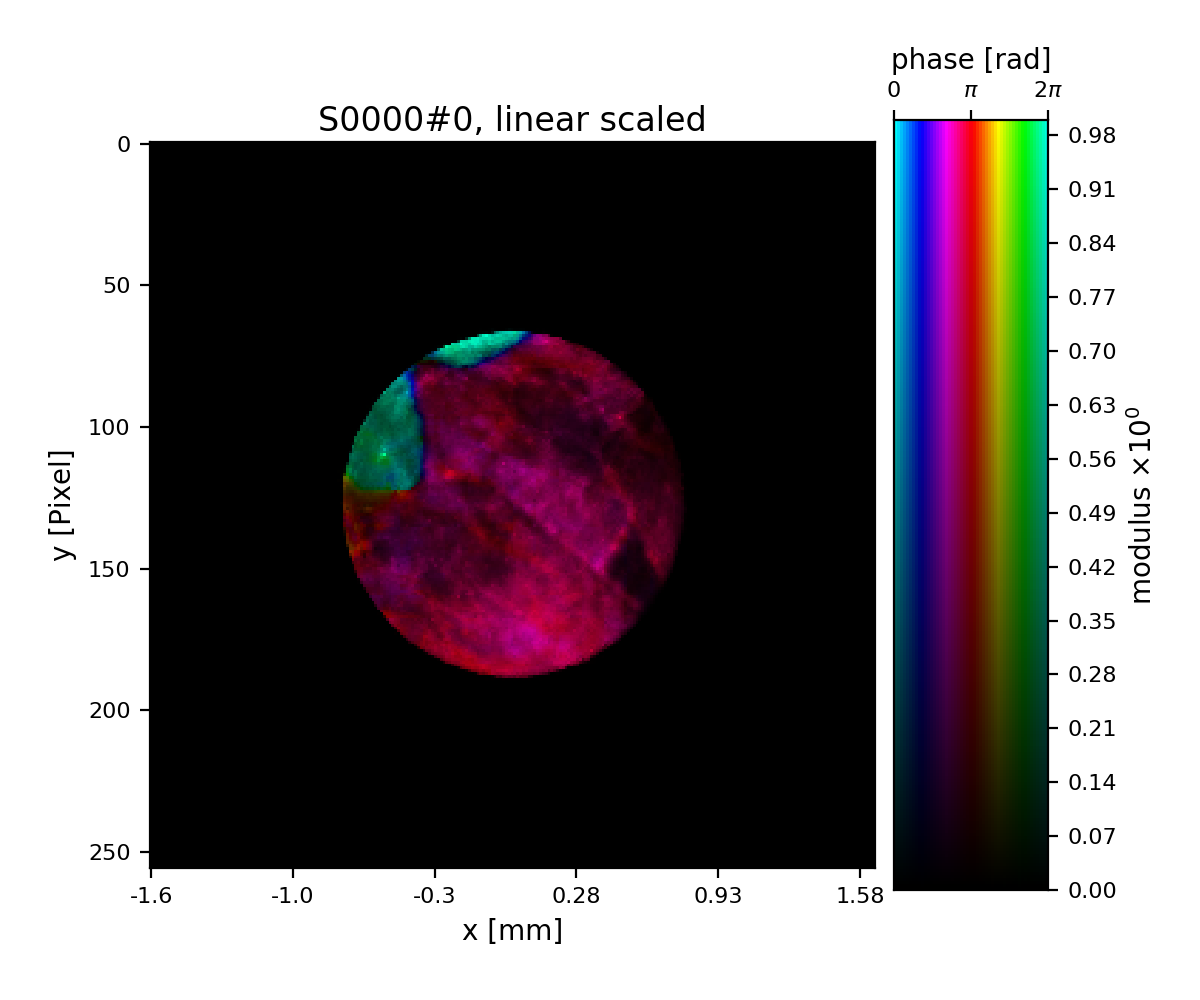

<IPython.core.display.Javascript object>

In [14]:
#optional - sanity check to display diff and exit data.

#the exit wave chart is acting up... 

#todo - is there a way to feed the slices keyword a variable? then we could select which slice to view...
print('This is the first and second exit wave in the series and their corresponding diffraction patterns.')
fig = plt.figure()
fig = u.plot_storage(P.exit.storages.values()[0], 6)
#fig.savefig('images/exit_%d' % (fig.number))

fig = plt.figure()
diff_storage = P.diff.storages.values()[0]
fig = u.plot_storage(diff_storage, 7, slices=':2,:,:', modulus='log')
#fig.savefig('diffraction_patterns.png', dpi=300)


In [15]:
#last part - store all this data

with open(save_path+'\\geometry.txt', 'w') as f:
    f.write('distance %.4e\n' % G.p.distance)
    f.write('energy %.4e\n' % G.energy)
    f.write('psize %.4e\n' % G.psize[0])
    f.write('shape %d\n' % G.shape[0])
    f.close()

with open(save_path+'\\positions.txt', 'w') as f:
    os.mkdir(save_path+'\\ccd\\')
    probe_frame = '\\ccd\\probe.npy'
    f.write(probe_frame)
    frame = pods[0].probe.astype(np.complex64)
    np.save(save_path+probe_frame, frame)
    for pod in pods:
        diff_frame = '\\ccd\\diffraction_%04d.npy' % pod.di_view.layer
        f.write(diff_frame+' %.4e %.4e\n' % tuple(pod.ob_view.coord))
        frame = pod.diff.astype(np.int32)
        np.save(save_path+diff_frame, frame)

import pickle
pickle.dump(simulationSettings, open(save_path+'\\meta.p', 'wb'))
